### Introduction: Manual Feature Engineering

If you are new to this competition, I highly suggest checking out [this notebook](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction/) to get started.

In this notebook, we will explore making features by hand for the Home Credit Default Risk competition. In an earlier notebook, we used only the `application` data in order to build a model. The best model we made from this data achieved a score on the leaderboard around 0.74. In order to better this score, we will have to include more information from the other dataframes. Here, we will look at using information from the `bureau` and `bureau_balance` data. The definitions of these data files are:

* bureau: information about client's previous loans with other financial institutions reported to Home Credit. Each previous loan has its own row.
* bureau_balance: monthly information about the previous loans. Each month has its own row.

Manual feature engineering can be a tedious process (which is why we use automated feature engineering with featuretools!) and often relies on domain expertise. Since I have limited domain knowledge of loans and what makes a person likely to default, I will instead concentrate of getting as much info as possible into the final training dataframe. The idea is that the model will then pick up on which features are important rather than us having to decide that. Basically, our approach is to make as many features as possible and then give them all to the model to use! Later, we can perform feature reduction using the feature importances from the model or other techniques such as PCA.

The process of manual feature engineering will involve plenty of Pandas code, a little patience, and a lot of great practice manipulation data. Even though automated feature engineering tools are starting to be made available, feature engineering will still have to be done using plenty of data wrangling for a little while longer.

In [144]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

### Example: Counts of a client's previous loans

To illustrate the general process of manual feature engineering, we will first simply get the count of a client's previous loans at other financial institutions. This requires a number of Pandas operations we will make heavy use of throughout the notebook:

* `groupby`: group a dataframe by a column. In this case we will group by the unique client, the `SK_ID_CURR` column
* `agg`: perform a calculation on the grouped data such as taking the mean of columns. We can either call the function directly (`grouped_df.mean()`) or use the `agg` function together with a list of transforms (`grouped_df.agg([mean, max, min, sum])`)
* `merge`: match the aggregated statistics to the appropriate client. We need to merge the original training data with the calculated stats on the `SK_ID_CURR` column which will insert `NaN` in any cell for which the client does not have the corresponding statistic

We also use the (`rename`) function quite a bit specifying the columns to be renamed as a dictionary. This is useful in order to keep track of the new variables we create.

This might seem like a lot, which is why we'll eventually write a function to do this process for us. Let's take a look at implementing this by hand first.

In [146]:
# Read in bureau
bureau = pd.read_csv('bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [147]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [148]:
pd.set_option('display.max_columns', None)
# Join to the training dataframe
train = pd.read_csv('app_train.csv', index_col=0)
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATIO

In [149]:
train.shape

(307511, 242)

Scroll all the way to the right to see the new column.

### Assessing Usefulness of New Variable with r value

To determine if the new variable is useful, we can calculate the Pearson Correlation Coefficient (r-value) between this variable and the target. This measures the strength of a linear relationship between two variables and ranges from -1 (perfectly negatively linear) to +1 (perfectly positively linear). The r-value is not best measure of the "usefulness" of a new variable, but it can give a first approximation of whether a variable will be helpful to a machine learning model. The larger the r-value of a variable with respect to the target, the more a change in this variable is likely to affect the value of the target. Therefore, we look for the variables with the greatest absolute value r-value relative to the target.

We can also visually inspect a relationship with the target using the Kernel Density Estimate (KDE) plot.

### Kernel Density Estimate Plots

The kernel density estimate plot shows the distribution of a single variable (think of it as a smoothed histogram). To see the different in distributions dependent on the value of a categorical variable, we can color the distributions differently according to the category. For example, we can show the kernel density estimate of the `previous_loan_count` colored by whether the `TARGET` = 1 or 0. The resulting KDE will show any significant differences in the distribution of the variable between people who did not repay their loan (`TARGET == 1`) and the people who did (`TARGET == 0`). This can serve as an indicator of whether a variable will be 'relevant' to a machine learning model.

We will put this plotting functionality in a function to re-use for any variable.

In [153]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):

    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])

    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()

    plt.figure(figsize = (8, 4))

    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')

    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();

    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)


We can test this function using the `EXT_SOURCE_3` variable which we [found to be one of the most important variables ](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction) according to a Random Forest and Gradient Boosting Machine.

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460


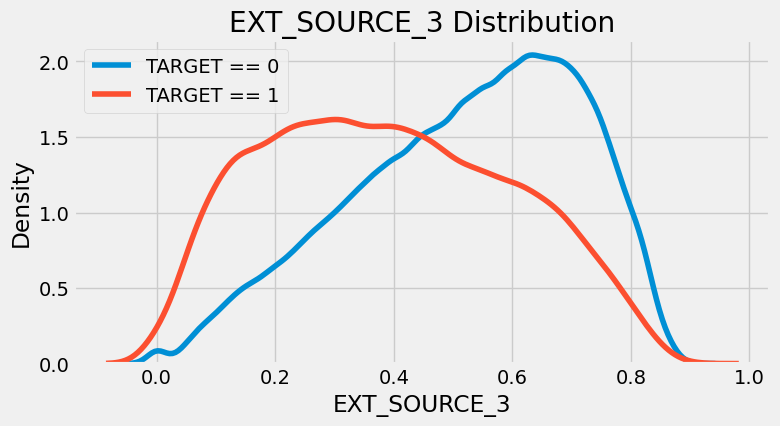

In [155]:
kde_target('EXT_SOURCE_3', train)

Now for the new variable we just made, the number of previous loans at other institutions.

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


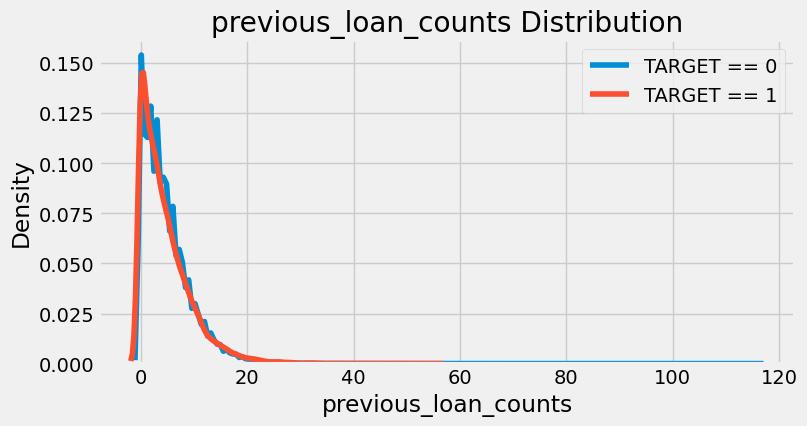

In [157]:
kde_target('previous_loan_counts', train)

From this it's difficult to tell if this variable will be important. The correlation coefficient is extremely weak and there is almost no noticeable difference in the distributions.

Let's move on to make a few more variables from the bureau dataframe. We will take the mean, min, and max of every numeric column in the bureau dataframe.

### Aggregating Numeric Columns

To account for the numeric information in the `bureau` dataframe, we can compute statistics for all the numeric columns. To do so, we `groupby` the client id, `agg` the grouped dataframe, and merge the result back into the training data. The `agg` function will only calculate the values for the numeric columns where the operation is considered valid. We will stick to using `'mean', 'max', 'min', 'sum'` but any function can be passed in here. We can even write our own function and use it in an `agg` call.

In [160]:
# Group by the client id, calculate aggregation statistics
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).select_dtypes(include=[np.number]).groupby('SK_ID_CURR').agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                   DAYS_CREDIT_ENDDATE                                      \
  mean max min sum               count        mean     max     min     sum   
0  0.0   0   0   0                   7   82.428571  1778.0 -1329.0   577.0   
1  0.0   0   0   0                   6 -349.000000   780.0 -1072.0 -2094.0   
2  0.0   0   0   0                   4 -544.500000  1216.0 -2434.0 -2178.0   
3  0.0   0   0   0                   2 -488.500000  -382.0  -595.0  -977.0   
4  0.0   0   0   0                   3  439.333333  1324.0  -128.0  1318.0   

  DAYS_ENDDATE_FACT                                      \
              count         mean    max     min     sum   
0                 4  -825.500000 -544.0 -1328.0 -3302.0   
1                 6  -697.500000  -36.0 -1185.0 -4185.0   
2                 3 -1097.333333 -540.0 -2131.0 -3292.0   
3                 2  -532.500000 -382.0  -683.0 -1065.0   
4                 1  -123.000000 -123.0  -123.0  -123.0   

  AMT_CREDIT_MAX_OVERDUE                                     \
                   count      mean       max  min       sum   
0                      0       NaN       NaN  NaN     0.000   
1                      5  1681.029  5043.645  0.0  8405.145   
2                      4     0.000     0.000  0.0     0.000   
3                      1     0.000     0.000  0.0     0.000   
4                      1     0.000     0.000  0.0     0.000   

  CNT_CREDIT_PROLONG                  AMT_CREDIT_SUM                           \
               count mean max min sum          count           mean       max   
0                  7  0.0   0   0   0              7  207623.571429  378000.0   
1                  8  0.0   0   0   0              8  108131.945625  450000.0   
2                  4  0.0   0   0   0              4  254350.125000  810000.0   
3                  2  0.0   0   0   0              2   94518.900000   94537.8   
4                  3  0.0   0   0   0              3  219042.000000  568800.0   

                        AMT_CREDIT_SUM_DEBT                                \
       min          sum               count           mean       max  min   
0  85500.0  1453365.000                   7   85240.928571  373239.0  0.0   
1      0.0   865055.565                   5   49156.200000  245781.0  0.0   
2  22248.0  1017400.500                   4       0.000000       0.0  0.0   
3  94500.0   189037.800                   2       0.000000       0.0  0.0   
4  29826.0   657126.000                   3  189469.500000  543087.0  0.0   

            AMT_CREDIT_SUM_LIMIT                                             \
        sum                count          mean         max  min         sum   
0  596686.5                    6       0.00000       0.000  0.0       0.000   
1  245781.0                    4    7997.14125   31988.565  0.0   31988.565   
2       0.0                    4  202500.00000  810000.000  0.0  810000.000   
3       0.0                    2       0.00000       0.000  0.0       0.000   
4  568408.5                    3       0.00000       0.000  0.0       0.000   

  AMT_CREDIT_SUM_OVERDUE                     DAYS_CREDIT_UPDATE              \
                   count mean  max  min  sum              count        mean   
0                      7  0.0  0.0  0.0  0.0                  7  -93.142857   
1                      8  0.0  0.0  0.0  0.0                  8 -499.875000   
2                      4  0.0  0.0  0.0  0.0                  4 -816.000000   
3 

We need to create new names for each of these columns. The following code makes new names by appending the stat to the name. Here we have to deal with the fact that the dataframe has a multi-level index. I find these confusing and hard to work with, so I try to reduce to a single level index as quickly as possible.

In [162]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':

        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [163]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.500000,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.500000,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,4,-544.500000,1216.0,-2434.0,-2178.0,3,-1097.333333,-540.0,-2131.0,-3292.0,4,0.000,0.000,0.0,0.000,4,0.0,0,0,0,4,254350.125000,810000.0,22248.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,810000.000,0.0,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,2,-488.500000,-382.0,-595.0,-977.0,2,-532.500000,-382.0,-683.0,-1065.0,1,0.000,0.000,0.0,0.000,2,0.0,0,0,0,2,94518.900000,94537.8,94500.0,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.000,0.0,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,3,439.333333,1324.0,-128.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.000,0.0,0.000,3,0.0,0,0,0,3,219042.000000,568800.0,29826.0,657126.000,3,189469.500000,543087.0,0.0,568408.5,3,0.00000,0.000,0.0,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


Now we simply merge with the training data as we did before.

In [165]:
# Merge with the training data
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATIO

In [166]:
train.shape

(307511, 302)

### Correlations of Aggregated Values with Target

We can calculate the correlation of all new values with the target. Again, we can use these as an approximation of the variables which may be important for modeling.

In [168]:
# List of new correlations
new_corrs = []

# Iterate through the columns
for col in columns:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])

    # Append the list as a tuple

    new_corrs.append((col, corr))

In the code below, we sort the correlations by the magnitude (absolute value) using the `sorted` Python function. We also make use of an anonymous `lambda` function, another important Python operation that is good to know.

In [170]:
# Sort the correlations by the absolute value
# Make sure to reverse to put the largest values at the front of list
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.089728967219981),
 ('bureau_DAYS_CREDIT_min', 0.07524825103010374),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968684),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.055887379843920795),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.053734895601020585),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758622),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997309),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.048853502611115936),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433483553),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.04286392247073023),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484667),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.0414036353530601),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.03658963469632898),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921615996),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.03049230665332547)]

None of the new variables have a significant correlation with the TARGET. We can look at the KDE plot of the highest correlated variable, `bureau_DAYS_CREDIT_mean`, with the target in  in terms of absolute magnitude correlation.

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


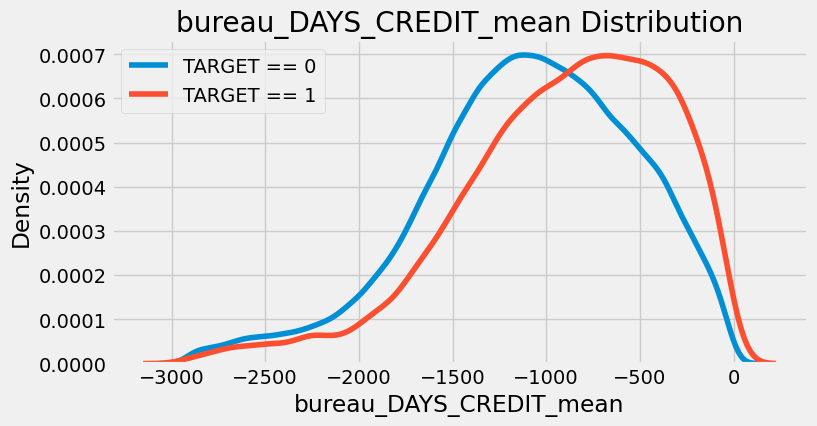

In [47]:
kde_target('bureau_DAYS_CREDIT_mean', train)

The definition of this column is: "How many days before current application did client apply for Credit Bureau credit". My interpretation is this is the number of days that the previous loan was applied for before the application for a loan at Home Credit. Therefore, a larger negative number indicates the loan was further before the current loan application. We see an extremely weak positive relationship between the average of this variable and the target meaning that clients who applied for loans further in the past potentially are more likely to repay loans at Home Credit. With a correlation this weak though, it is just as likely to be noise as a signal.

#### The Multiple Comparisons Problem

When we have lots of variables, we expect some of them to be correlated just by pure chance, a [problem known as multiple comparisons](https://towardsdatascience.com/the-multiple-comparisons-problem-e5573e8b9578). We can make hundreds of features, and some will turn out to be corelated with the target simply because of random noise in the data. Then, when our model trains, it may overfit to these variables because it thinks they have a relationship with the target in the training set, but this does not necessarily generalize to the test set. There are many considerations that we have to take into account when making features!

## Homework 6. Part 1
### Logistic regression model. Data with engineered features from bureau.csv

In [187]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

X = train.drop(columns = ['TARGET'])
y = train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (206032, 301)
Testing data shape:  (101479, 301)


In [189]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
logr = LogisticRegression()

# Train on the training data
logr.fit(X_train, y_train)

LogisticRegression()

In [55]:
pred_proba = logr.predict_proba(X_test)[:, 1]

### ROC AUC score, part 1

In [58]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, pred_proba)

0.7480041595770592

In [43]:
#saving dataset
train.to_csv('app_train_p1.csv')

### Fitting test data and submission

In [232]:
test = pd.read_csv('app_test.csv')
test = test.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
test.to_csv('app_test_p1.csv')

train_labels = train['TARGET']
train, test = train.align(test, join = 'inner', axis = 1)
train['TARGET'] = train_labels

In [193]:
X_train = train.drop(columns = ['TARGET'])
y_train = train['TARGET']

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

X_train = imputer.fit_transform(X_train)
test = imputer.transform(test)

X_train =scaler.fit_transform(X_train)
test = scaler.transform(test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 301)
Testing data shape:  (48744, 301)


In [195]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [223]:
log_reg_pred = log_reg.predict_proba(test)[:, 1]
log_reg_pred.shape

(48744,)

In [227]:
app_test = pd.read_csv('app_test.csv')
submit = pd.DataFrame(app_test['SK_ID_CURR'])
submit['TARGET'] = log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.048360
1,100005,0.191150
2,100013,0.035816
3,100028,0.037528
4,100038,0.120471


In [229]:
submit.to_csv('hw_part1.csv', index = False)